# linear regreesion（线性回归）
注意：python版本为3.6，
安装TensorFlow的方法：pip install tensorflow

In [1]:
import pandas as pd
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="dark")
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
df = pd.read_csv('ex1data1.txt', names=['population', 'profit'])#读取数据并赋予列名

In [3]:
df.head()#看前五行

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
population    97 non-null float64
profit        97 non-null float64
dtypes: float64(2)
memory usage: 1.6 KB


In [5]:
df.shape

(97, 2)

***
# 看下原始数据

D:\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


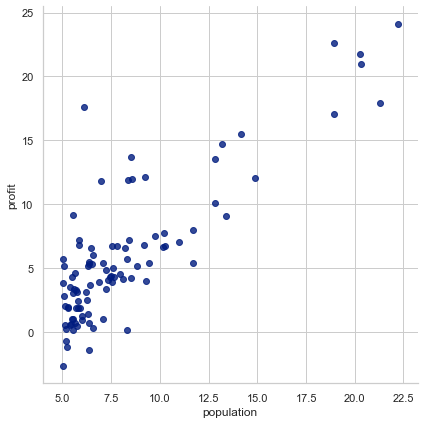

In [6]:
sns.lmplot('population', 'profit', df, size=6, fit_reg=False)
plt.show()

In [7]:
def get_X(df):#读取特征
#     """
#     use concat to add intersect feature to avoid side effect
#     not efficient for big dataset though
#     """
    ones = pd.DataFrame({'ones': np.ones(len(df))})#ones是m行1列的dataframe
    data = pd.concat([ones, df], axis=1)  # 合并数据，根据列合并
    return data.iloc[:, :-1].as_matrix()  # 这个操作返回 ndarray,不是矩阵


def get_y(df):#读取标签
#     '''assume the last column is the target'''
    return np.array(df.iloc[:, -1])#df.iloc[:, -1]是指df的最后一列


def normalize_feature(df):
#     """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())#特征缩放

多变量的假设 h 表示为：\\[{{h}_{\theta }}\left( x \right)={{\theta }_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}\\] 
这个公式中有n+1个参数和n个变量，为了使得公式能够简化一些，引入${{x}_{0}}=1$，则公式转化为：  
此时模型中的参数是一个n+1维的向量，任何一个训练实例也都是n+1维的向量，特征矩阵X的维度是 m*(n+1)。 因此公式可以简化为：${{h}_{\theta }}\left( x \right)={{\theta }^{T}}X$，其中上标T代表矩阵转置。


In [8]:
def linear_regression(X_data, y_data, alpha, epoch, optimizer=tf.train.GradientDescentOptimizer):# 这个函数是旧金山的一个大神Lucas Shen写的
      # placeholder for graph input
    X = tf.placeholder(tf.float32, shape=X_data.shape)
    y = tf.placeholder(tf.float32, shape=y_data.shape)

    # construct the graph
    with tf.variable_scope('linear-regression'):
        W = tf.get_variable("weights",
                            (X_data.shape[1], 1),
                            initializer=tf.constant_initializer())  # n*1

        y_pred = tf.matmul(X, W)  # m*n @ n*1 -> m*1

        loss = 1 / (2 * len(X_data)) * tf.matmul((y_pred - y), (y_pred - y), transpose_a=True)  # (m*1).T @ m*1 = 1*1

    opt = optimizer(learning_rate=alpha)
    opt_operation = opt.minimize(loss)

    # run the session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_data = []

        for i in range(epoch):
            _, loss_val, W_val = sess.run([opt_operation, loss, W], feed_dict={X: X_data, y: y_data})
            loss_data.append(loss_val[0, 0])  # because every loss_val is 1*1 ndarray

            if len(loss_data) > 1 and np.abs(loss_data[-1] - loss_data[-2]) < 10 ** -9:  # early break when it's converged
                # print('Converged at epoch {}'.format(i))
                break

    # clear the graph
    tf.reset_default_graph()
    return {'loss': loss_data, 'parameters': W_val}  # just want to return in row vector format

In [9]:
data = pd.read_csv('ex1data1.txt', names=['population', 'profit'])#读取数据，并赋予列名

data.head()#看下数据前5行

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


# 计算代价函数
$$J\left( \theta  \right)=\frac{1}{2m}\sum\limits_{i=1}^{m}{{{\left( {{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}} \right)}^{2}}}$$
其中：\\[{{h}_{\theta }}\left( x \right)={{\theta }^{T}}X={{\theta }_{0}}{{x}_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}\\] 

In [10]:
X = get_X(data)
print(X.shape, type(X))

y = get_y(data)
print(y.shape, type(y))
#看下数据维度

(97, 2) <class 'numpy.ndarray'>
(97,) <class 'numpy.ndarray'>


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [11]:
theta = np.zeros(X.shape[1])#X.shape[1]=2,代表特征数n

In [12]:
def lr_cost(theta, X, y):
#     """
#     X: R(m*n), m 样本数, n 特征数
#     y: R(m)
#     theta : R(n), 线性回归的参数
#     """
    m = X.shape[0]#m为样本数

    inner = X @ theta - y  # R(m*1)，X @ theta等价于X.dot(theta)

    # 1*m @ m*1 = 1*1 in matrix multiplication
    # but you know numpy didn't do transpose in 1d array, so here is just a
    # vector inner product to itselves
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)

    return cost

In [13]:
lr_cost(theta, X, y)#返回theta的值

32.072733877455676

# batch gradient decent（批量梯度下降）
$${{\theta }_{j}}:={{\theta }_{j}}-\alpha \frac{\partial }{\partial {{\theta }_{j}}}J\left( \theta  \right)$$

In [14]:
def gradient(theta, X, y):
    m = X.shape[0]

    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)，X @ theta等价于X.dot(theta)

    return inner / m

In [15]:
def batch_gradient_decent(theta, X, y, epoch, alpha=0.01):
#   拟合线性回归，返回参数和代价
#     epoch: 批处理的轮数
#     """
    cost_data = [lr_cost(theta, X, y)]
    _theta = theta.copy()  # 拷贝一份，不和原来的theta混淆

    for _ in range(epoch):
        _theta = _theta - alpha * gradient(_theta, X, y)
        cost_data.append(lr_cost(_theta, X, y))

    return _theta, cost_data
#批量梯度下降函数

In [16]:
epoch = 500
final_theta, cost_data = batch_gradient_decent(theta, X, y, epoch)

In [17]:
final_theta
#最终的theta

array([-2.28286727,  1.03099898])

In [18]:
cost_data
# 看下代价数据

[32.072733877455676,
 6.737190464870011,
 5.931593568604956,
 5.901154707081388,
 5.895228586444221,
 5.89009494311733,
 5.885004158443646,
 5.8799324804914175,
 5.874879094762573,
 5.869843911806385,
 5.8648268653129305,
 5.8598278899321805,
 5.85484692057229,
 5.849883892376587,
 5.844938740722034,
 5.840011401218361,
 5.835101809707228,
 5.830209902261388,
 5.825335615183862,
 5.820478885007099,
 5.815639648492154,
 5.810817842627869,
 5.806013404630045,
 5.80122627194063,
 5.796456382226899,
 5.791703673380653,
 5.7869680835173956,
 5.782249550975539,
 5.777548014315596,
 5.772863412319382,
 5.768195683989212,
 5.76354476854712,
 5.758910605434047,
 5.754293134309078,
 5.749692295048629,
 5.745108027745684,
 5.740540272709014,
 5.735988970462381,
 5.731454061743792,
 5.726935487504702,
 5.722433188909257,
 5.717947107333529,
 5.713477184364749,
 5.709023361800549,
 5.704585581648199,
 5.700163786123856,
 5.695757917651815,
 5.691367918863752,
 5.68699373259798,
 5.682635301898707,


In [19]:
# 计算最终的代价
lr_cost(final_theta, X, y)

4.713809531116866

# visualize cost data（代价数据可视化）

D:\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


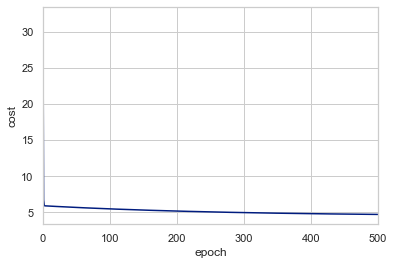

In [20]:
ax = sns.tsplot(cost_data, time=np.arange(epoch+1))
ax.set_xlabel('epoch')
ax.set_ylabel('cost')
plt.show()
#可以看到从第二轮代价数据变换很大，接下来平稳了

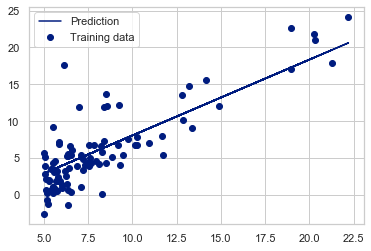

In [21]:
b = final_theta[0] # intercept，Y轴上的截距
m = final_theta[1] # slope，斜率

plt.scatter(data.population, data.profit, label="Training data")
plt.plot(data.population, data.population*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

# 3- 选修章节

In [22]:
raw_data = pd.read_csv('ex1data2.txt', names=['square', 'bedrooms', 'price'])
raw_data.head()

,square,bedrooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


# 标准化数据
最简单的方法是令：

 

其中  是平均值，sn 是标准差。


In [23]:
def normalize_feature(df):
#     """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [24]:
data = normalize_feature(raw_data)
data.head()

,square,bedrooms,price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


# 2. multi-var batch gradient decent（多变量批量梯度下降）

In [25]:
X = get_X(data)
print(X.shape, type(X))

y = get_y(data)
print(y.shape, type(y))#看下数据的维度和类型

(47, 3) <class 'numpy.ndarray'>
(47,) <class 'numpy.ndarray'>


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [26]:
alpha = 0.01#学习率
theta = np.zeros(X.shape[1])#X.shape[1]：特征数n
epoch = 500#轮数

In [27]:
final_theta, cost_data = batch_gradient_decent(theta, X, y, epoch, alpha=alpha)

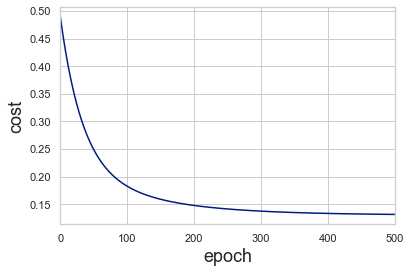

In [28]:
sns.tsplot(time=np.arange(len(cost_data)), data = cost_data)
plt.xlabel('epoch', fontsize=18)
plt.ylabel('cost', fontsize=18)
plt.show()

In [29]:
final_theta

array([-1.20848957e-16,  8.30383883e-01,  8.23982853e-04])

# 3. learning rate（学习率）

In [30]:
base = np.logspace(-1, -5, num=4)
candidate = np.sort(np.concatenate((base, base*3)))
print(candidate)

[1.00000000e-05 3.00000000e-05 2.15443469e-04 6.46330407e-04
 4.64158883e-03 1.39247665e-02 1.00000000e-01 3.00000000e-01]


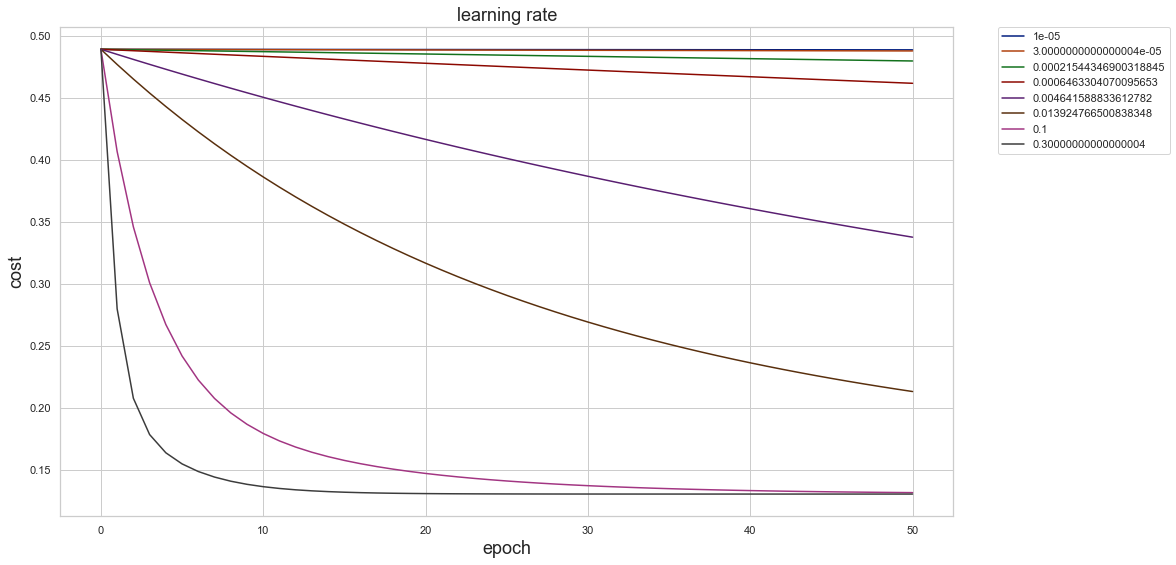

In [31]:
epoch=50

fig, ax = plt.subplots(figsize=(16, 9))

for alpha in candidate:
    _, cost_data = batch_gradient_decent(theta, X, y, epoch, alpha=alpha)
    ax.plot(np.arange(epoch+1), cost_data, label=alpha)

ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('learning rate', fontsize=18)
plt.show()

# 4. normal equation（正规方程）
正规方程是通过求解下面的方程来找出使得代价函数最小的参数的：$\frac{\partial }{\partial {{\theta }_{j}}}J\left( {{\theta }_{j}} \right)=0$ 。
 假设我们的训练集特征矩阵为 X（包含了${{x}_{0}}=1$）并且我们的训练集结果为向量 y，则利用正规方程解出向量 $\theta ={{\left( {{X}^{T}}X \right)}^{-1}}{{X}^{T}}y$ 。
上标T代表矩阵转置，上标-1 代表矩阵的逆。设矩阵$A={{X}^{T}}X$，则：${{\left( {{X}^{T}}X \right)}^{-1}}={{A}^{-1}}$

梯度下降与正规方程的比较：

梯度下降：需要选择学习率α，需要多次迭代，当特征数量n大时也能较好适用，适用于各种类型的模型	

正规方程：不需要选择学习率α，一次计算得出，需要计算${{\left( {{X}^{T}}X \right)}^{-1}}$，如果特征数量n较大则运算代价大，因为矩阵逆的计算时间复杂度为O(n3)，通常来说当n小于10000 时还是可以接受的，只适用于线性模型，不适合逻辑回归模型等其他模型



In [32]:
# 正规方程
def normalEqn(X, y):
    theta = np.linalg.inv(X.T@X)@X.T@y#X.T@X等价于X.T.dot(X)
    return theta

In [33]:
final_theta2=normalEqn(X, y)#感觉和批量梯度下降的theta的值有点差距
final_theta2

array([-1.14491749e-16,  8.84765988e-01, -5.31788197e-02])

# run the tensorflow graph over several optimizer

In [34]:
X_data = get_X(data)
print(X_data.shape, type(X_data))

y_data = get_y(data).reshape(len(X_data), 1)  # special treatment for tensorflow input data
print(y_data.shape, type(y_data))

(47, 3) <class 'numpy.ndarray'>
(47, 1) <class 'numpy.ndarray'>


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [35]:
epoch = 2000
alpha = 0.01

In [36]:
optimizer_dict={'GD': tf.train.GradientDescentOptimizer,
                'Adagrad': tf.train.AdagradOptimizer,
                'Adam': tf.train.AdamOptimizer,
                'Ftrl': tf.train.FtrlOptimizer,
                'RMS': tf.train.RMSPropOptimizer
               }
results = []
for name in optimizer_dict:
    res = linear_regression(X_data, y_data, alpha, epoch, optimizer=optimizer_dict[name])
    res['name'] = name
    results.append(res)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# 画图

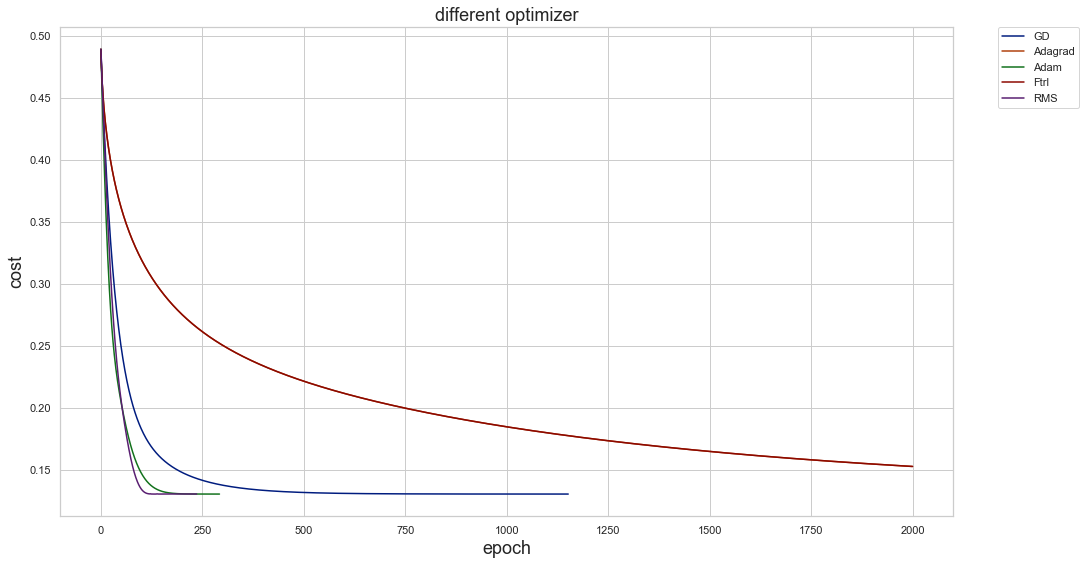

In [37]:
fig, ax = plt.subplots(figsize=(16, 9))

for res in results: 
    loss_data = res['loss']
    
#     print('for optimizer {}'.format(res['name']))
#     print('final parameters\n', res['parameters'])
#     print('final loss={}\n'.format(loss_data[-1]))
    ax.plot(np.arange(len(loss_data)), loss_data, label=res['name'])

ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('different optimizer', fontsize=18)
plt.show()